In [81]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import xarray as xr
import pandas as pd
from tqdm import tqdm
import warnings
import cartopy.crs as ccrs
from sklearn.feature_selection import mutual_info_regression

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
# plt.rcdefaults()

import sys 
sys.path.append("../scripts")
from InfoTheoryMetrics import I, optbins, H, I_jugaad, freedman_diaconis_bins

# This notebook investigates some technical questions about the flattening "jugaad" used to estimate MI

In [2]:
# Load in the datasets
f = xr.open_dataset("../data/ensembles/large_psl_decadal_ensemble_no_extrapolate.nc").drop_dims(["bnds"])
obs = xr.open_dataset("../data/obs/hadslp2/hadslp2_monthly_1850_2004.nc")
obs = obs.where(obs["time.year"]>=1962, drop=True)
obs = obs.where(obs["time.year"]<1972, drop=True)
obs = obs.sortby("lon")

# Fine-grain the observations to match the model outputs
with warnings.catch_warnings(action="ignore"):
    obs["time"] = obs.indexes["time"].to_datetimeindex()
obs = obs.interp_like(f, kwargs={"fill_value":"extrapolate"})
# f = f.interp_like(obs, kwargs={"fill_value":"extrapolate"})

# Linearly detrend the data
obs_lin_trend = xr.polyval(obs["time"], obs.psl.polyfit(dim='time', deg=1).polyfit_coefficients)
obs["psl"] = obs["psl"] - obs_lin_trend

f_lin_trend = xr.polyval(f["time"], f.psl.polyfit(dim='time', skipna=True, deg=1).polyfit_coefficients)
f["psl"] = f["psl"] - f_lin_trend

s = f.mean("n")

In [17]:
x,y = 20,14
obs_test = obs.isel(lat=y, lon=x).psl.to_numpy()
signal_test = s.isel(lat=y, lon=x).psl.to_numpy()

o_bins = optbins(obs_test, 80)
s_bins = optbins(signal_test, 80)
num_tiles = np.arange(1,130)

H_g = np.zeros((5, len(num_tiles)))
H_s = np.zeros((2, len(num_tiles)))
obs_bins = freedman_diaconis_bins(obs_test)
signal_bins = freedman_diaconis_bins(signal_test)
for i in tqdm(range(len(num_tiles))):
    num = num_tiles[i]
    obs_tiled = np.tile(obs_test, num)
    signal_tiled = np.tile(signal_test, num)
    obs_tiled_bins = freedman_diaconis_bins(obs_tiled)
#     print(obs_tiled_bins)
#     signal_tiled_bins = freedman_diaconis_bins(signal_tiled)
    
    # Entropy
    H_g[0,i] = H(obs_tiled, bins=obs_bins)
    H_g[1,i] = H(obs_tiled, bins=obs_tiled_bins)
    H_g[2,i] = mutual_info_regression(obs_tiled.T.reshape(-1,1), obs_tiled, n_neighbors=3)[0]
    H_g[3,i] = mutual_info_regression(obs_tiled.T.reshape(-1,1), obs_tiled, n_neighbors=4)[0]
    H_g[4,i] = mutual_info_regression(obs_tiled.T.reshape(-1,1), obs_tiled, n_neighbors=5)[0]
    
    # MI
#     s_bins = optbins(obs_tiled, 50)
#     s_bins_list.append(s_bins)
#     mi_kraskov.append(mutual_info_regression(obs_tiled.T.reshape(-1,1), signal_tiled)[0])
#     mi_hist.append(I(obs_tiled, signal_tiled, nbins_alt=(o_bins, s_bins))[0])

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:11<00:00, 10.96it/s]


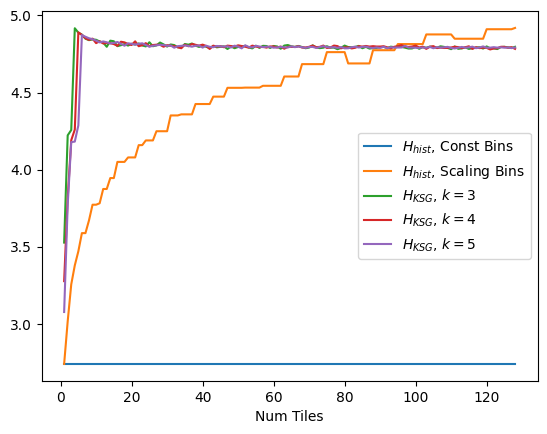

In [25]:
# plt.plot(num_tiles, entropies_hist, label=r'$H_{hist}$ Knuth')
STOP = -1
plt.plot(num_tiles[:STOP], H_g[0,:STOP], label=r'$H_{hist}$, Const Bins')
plt.plot(num_tiles[:STOP], H_g[1,:STOP], label=r'$H_{hist}$, Scaling Bins')
plt.plot(num_tiles[:STOP], H_g[2,:STOP], label=r'$H_{KSG}$, $k=3$')
plt.plot(num_tiles[:STOP], H_g[3,:STOP], label=r'$H_{KSG}$, $k=4$')
plt.plot(num_tiles[:STOP], H_g[4,:STOP], label=r'$H_{KSG}$, $k=5$')
plt.xlabel("Num Tiles")
plt.legend()

This graph illustrtaes one relevant way in which the tiling and the choice of bins matters for the entropy calculation. In this graph, we are repeatedly tiling the original data array together, so that the empirical pmf stays identical. So, we know that the entropy should stay identical as well, but observe the artificial inflation that it has on the calculation instead.

# How does $H_f$, the ensemble entropy change w.r.t. to tiling?

In [70]:
CONST_BIN = -1
NUM_SAMPLES = 30

H_f_fd_bins = np.zeros((len(f.n), NUM_SAMPLES))
H_f_knuth_bins = np.zeros((len(f.n), NUM_SAMPLES))
fd_bins = np.zeros((len(f.n), NUM_SAMPLES))
knuth_bins = np.zeros((len(f.n), NUM_SAMPLES))
H_f_const_bin = np.zeros((len(f.n), NUM_SAMPLES))

Ns = f.n.to_numpy()
for size in tqdm(Ns):
    for sample in range(NUM_SAMPLES):
        f_nt = f.isel(n=np.random.choice(Ns, size+1), lon=x, lat=y).psl.to_numpy()
        f_nt[np.isnan(f_nt)] = 0.0
        f_flat = f_nt.flatten()
        fd_b = freedman_diaconis_bins(f_flat)
        knuth_b = optbins(f_flat, 80)
        fd_bins[size, sample] = fd_b
        knuth_bins[size, sample] = knuth_b
        if size==0 and CONST_BIN==-1:
            CONST_BIN = fd_b
        H_f_fd_bins[size, sample] = H(f_flat, bins=fd_b)
        H_f_knuth_bins[size, sample] = H(f_flat, bins=knuth_b)
        H_f_const_bin[size, sample] = H(f_flat, bins=CONST_BIN)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.14it/s]


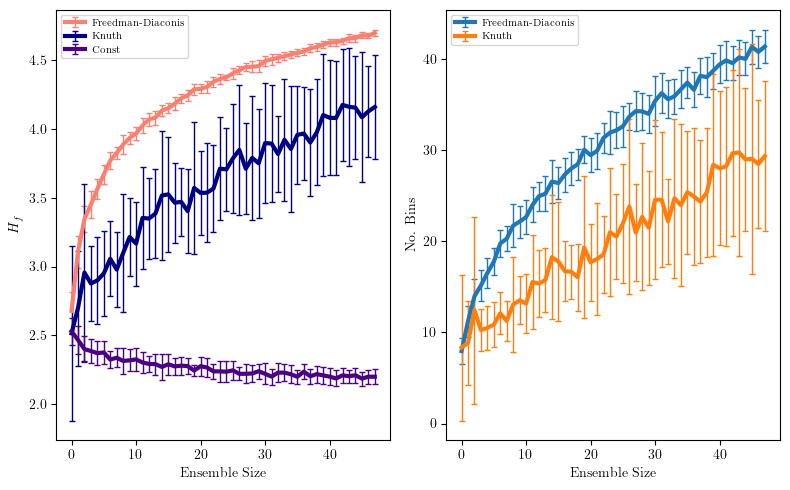

In [189]:
CAPSIZE = 2

fig, axs = plt.subplots(1,2, figsize=(8,5))
axs[0].errorbar(Ns, H_f_fd_bins.mean(axis=1), color='salmon',
             yerr=H_f_fd_bins.std(axis=1), linewidth=3, 
             elinewidth=1, capsize=CAPSIZE, label='Freedman-Diaconis')
axs[0].errorbar(Ns, H_f_knuth_bins.mean(axis=1), color='navy',
             yerr=H_f_knuth_bins.std(axis=1), linewidth=3, 
             elinewidth=1, capsize=CAPSIZE, label='Knuth')
axs[0].errorbar(Ns, H_f_const_bin.mean(axis=1), color='indigo',
             yerr=H_f_const_bin.std(axis=1), linewidth=3, 
             elinewidth=1, capsize=CAPSIZE, label='Const')
axs[0].set_ylabel("$H_f$")
axs[0].set_xlabel("Ensemble Size")
axs[0].legend(fontsize=7)

axs[1].errorbar(Ns, fd_bins.mean(axis=1), linewidth=3, 
             elinewidth=1, yerr=fd_bins.std(axis=1), capsize=CAPSIZE, label='Freedman-Diaconis')
axs[1].errorbar(Ns, knuth_bins.mean(axis=1), linewidth=3, 
             elinewidth=1, yerr=knuth_bins.std(axis=1), capsize=CAPSIZE, label='Knuth')
axs[1].set_xlabel("Ensemble Size")
axs[1].set_ylabel("No. Bins")
axs[1].legend(fontsize=7)

plt.tight_layout()

This plot shows that the estimated entropy of the ensemble increases as a consequence of scaling number of bins. In contrast, when the number of bins is kept constant, the entropy actually decreases as the ensemble size increases. The decrease is likely caused by the fact that increasingly many data points are being shoved into the same number of bins, making the empirical distribution more like a Gaussian. This shows that the choice of scaling number of bins contributes to a rise of entropy, and therefore justifies using the tiled version of $g(t)$ in the calculation of $\gamma_o$, so that it accounts for the effect of scaling bins.

# How do metrics change with ensemble size?

In [248]:
# my_lon=340; my_lat=45
# my_lon=240; my_lat=-50
# my_lon=10; my_lat=-45
my_lon, my_lat = 60, 0 # rho=1.6
# my_lon, my_lat = 120, -45 # rho=0.4

In [249]:
NUM_SAMPLES_2 = 60
Ns = np.arange(len(f.n))

I_gf = np.zeros((len(f.n), NUM_SAMPLES_2))
H_g = np.zeros((len(f.n), NUM_SAMPLES_2))
I_sf = np.zeros((len(f.n), NUM_SAMPLES_2))
H_f = np.zeros((len(f.n), NUM_SAMPLES_2))

var_metrics = np.zeros((3, len(f.n), NUM_SAMPLES_2))
for n in tqdm(Ns):
    for sample in range(NUM_SAMPLES_2):
        f_nt = f.sel(n=np.random.choice(Ns, n+1), lon=my_lon, lat=my_lat, method='nearest').psl.to_numpy()
        f_nt[np.isnan(f_nt)] = 0.0
        s_t = f_nt.mean(axis=0)
        g_t = obs.sel(lon=my_lon, lat=my_lat, method='nearest').psl.to_numpy()
        f_flat = f_nt.flatten()
        
        # Var Metrics
        rho_o = np.corrcoef(s_t, g_t)[0,1]
        rho_m = np.sqrt(s_t.var() / f_nt.var(axis=1).mean())
        rho_m_2 = 0.0
        if n+1 >=2:
            for i in range(n+1):
                LOO_g_t = f_nt[i, :]
                rest_of_f = [x for x in np.arange(n+1) if x!=i]
                rest_of_f = f_nt[rest_of_f]
                LOO_s_t = rest_of_f.mean(axis=0)
                rho_m_2 += np.corrcoef(LOO_g_t, LOO_s_t)[0,1] / (n+1)
        var_metrics[:,n,sample] = [rho_o, rho_m, rho_m_2]
        
        # Info Metrics
#         print(f_flat)
        fd_f_b = freedman_diaconis_bins(f_flat)
        fd_g_b = freedman_diaconis_bins(np.tile(g_t, n+1))
        fd_s_b = freedman_diaconis_bins(np.tile(s_t, n+1))
        I_gf[n, sample], H_g[n,sample], _ = I_jugaad(g_t, f_nt, nbins_alt=(fd_g_b, fd_f_b))
        I_sf[n, sample], _, H_f[n,sample] = I_jugaad(s_t, f_nt, nbins_alt=(fd_s_b, fd_f_b))

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.38it/s]


In [250]:
gam_o = I_gf / H_g 
gam_m = I_sf / H_f

lam_o = np.sqrt(1 - np.power(2, -2*I_gf))
lam_m = np.sqrt(1 - np.power(2, -2*I_sf))

rho_o = var_metrics[0]
rho_m = var_metrics[1]
rho_m_2 = var_metrics[2]

Lon=60 E, Lat=0 N


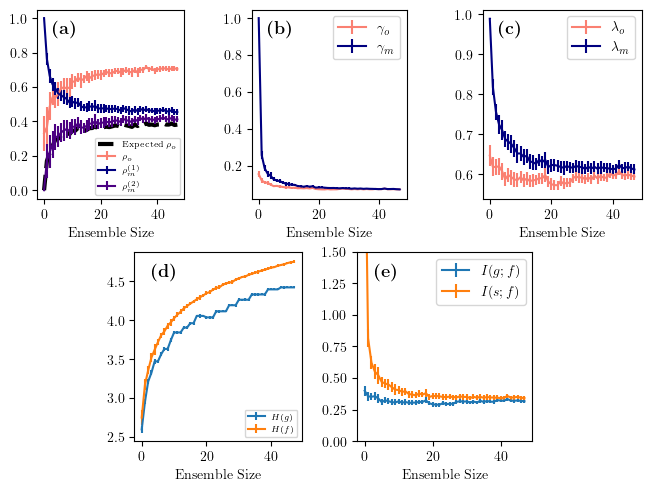

In [254]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained")
gs = GridSpec(4, 6, figure=fig)
rho_ax = fig.add_subplot(gs[0:2,0:2])
gam_ax = fig.add_subplot(gs[0:2,2:4])
lam_ax = fig.add_subplot(gs[0:2,4:6])
H_ax = fig.add_subplot(gs[2:4,1:3])
I_ax = fig.add_subplot(gs[2:4,3:5])

# fig, axs = plt.subplots(2,2, figsize=(5.5, 6))
gam_ax.errorbar(Ns, gam_o.mean(axis=1), yerr=gam_o.std(axis=1)/2, color='salmon', label='$\gamma_o$')
gam_ax.errorbar(Ns, gam_m.mean(axis=1), yerr=gam_m.std(axis=1)/2, color='navy', label='$\gamma_m$')
# axs[0,0].set_yscale("log")
# axs[0,0].set_yscale("log")
# axs[0,0].legend()
# axs[0,0].set_ylim([0,1.1])

lam_ax.errorbar(Ns, lam_o.mean(axis=1), yerr=lam_o.std(axis=1)/2,color='salmon',  label='$\lambda_o$')
lam_ax.errorbar(Ns, lam_m.mean(axis=1), yerr=lam_m.std(axis=1)/2, color='navy', label='$\lambda_m$')
# axs[0,1].legend()
# axs[0,1].set_ylim([0,1.1])


rho_ax.errorbar(Ns, rho_o.mean(axis=1), yerr=rho_o.std(axis=1)/2, color='salmon', label=r'$\rho_o$')
rho_ax.errorbar(Ns, rho_m.mean(axis=1), yerr=rho_m.std(axis=1)/2, color='navy', label=r'$\rho_m^{(1)}$')
rho_ax.plot(Ns, rho_m_2.mean(axis=1) / np.sqrt(1 + rho_m_2.mean(axis=1)**2), '--', linewidth=3, color='black', label=r'Expected $\rho_o$')
rho_ax.errorbar(Ns, rho_m_2.mean(axis=1), yerr=rho_m_2.std(axis=1)/2, color='indigo', label=r'$\rho_m^{(2)}$')
# axs[1,0].legend()
# axs[1,0].set_ylim([0,1.1])


I_ax.errorbar(Ns, I_gf.mean(axis=1), yerr=I_gf.std(axis=1)/2, label='$I(g;f)$')
I_ax.errorbar(Ns, I_sf.mean(axis=1), yerr=I_sf.std(axis=1)/2, label='$I(s;f)$')

H_ax.errorbar(Ns, H_g.mean(axis=1), yerr=I_gf.std(axis=1)/2, label='$H(g)$')
H_ax.errorbar(Ns, H_f.mean(axis=1), yerr=I_sf.std(axis=1)/2, label='$H(f)$')
# axs[1,1].legend()

axs = [rho_ax, gam_ax, lam_ax, H_ax, I_ax]
PLOT_TITLES = [r"\textbf{(a)}", r"\textbf{(b)}", r"\textbf{(c)}", r"\textbf{(d)}", r"\textbf{(e)}"]

# plt.tight_layout()
for i in range(len(axs)):
    ax = axs[i]
    if i==0:
        ax.legend(fontsize=6, loc='lower right')
    else:
        ax.legend()
    ax.set_xlabel("Ensemble Size")
    ax.text(0.1, 0.87, PLOT_TITLES[i], transform=ax.transAxes, fontsize=13)
H_ax.legend(loc='lower right', fontsize=6)
I_ax.set_ylim([0, 1.5])
print(f"Lon={np.round(my_lon,3)} E, Lat={np.round(my_lat,3)} N")

In [146]:
from scipy.stats import skew, kurtosis
from numpy import nanmean, nanvar

def compute_stat_moments(lon, lat, plot=False):
    flat_s = s.sel(lon=lon, lat=lat, method='nearest').psl.to_numpy().flatten()
    flat_obs = obs.sel(lon=lon, lat=lat, method='nearest').psl.to_numpy().flatten()
    flat_obs = flat_obs[~np.isnan(flat_obs)]
    flat_f = f.sel(lon=lon, lat=lat, method='nearest').psl.to_numpy().flatten()
    flat_s = flat_s[~np.isnan(flat_s)]
    flat_obs = flat_obs[~np.isnan(flat_obs)]
    flat_f = flat_f[~np.isnan(flat_f)]

    s_mean, s_var, s_skew, s_kurt = np.round(nanmean(flat_s), 3), np.round(nanvar(flat_s),3), np.round(skew(flat_s),3), np.round(kurtosis(flat_s),3)
    obs_mean, obs_var, obs_skew, obs_kurt = np.round(nanmean(flat_obs), 3), np.round(nanvar(flat_obs),3), np.round(skew(flat_obs),3), np.round(kurtosis(flat_obs),3)
    f_mean, f_var, f_skew, f_kurt = np.round(nanmean(flat_f), 3), np.round(nanvar(flat_f),3), np.round(skew(flat_f),3), np.round(kurtosis(flat_f),3)
    avg_f_var = 0
    for i in range(len(f.n)):
        f_i = f.sel(n=i, lon=lon, lat=lat, method='nearest').psl.to_numpy()
        avg_f_var += nanvar(f_i)/len(f.n)
    print(f"Lon={lon}, Lat={lat}")
    print(f"Sig -- mean={s_mean} | var={s_var} | skew={s_skew} | kurt={s_kurt}")
    print(f"Obs -- mean={obs_mean} | var={obs_var} | skew={obs_skew} | kurt={obs_kurt}")
    print(f"Ens -- mean={f_mean} | avgvar={avg_f_var} | var={f_var} | skew={f_skew} | kurt={f_kurt}")
    print(f"Model SNR = {np.sqrt(s_var / avg_f_var)}")
    print(f"Obs SNR = {np.sqrt(obs_var / avg_f_var)}")
    if plot:
        s_bins, s_edges = np.histogram(flat_s, density=True)
        obs_bins, obs_edges = np.histogram(flat_obs, density=True)
        f_bins, f_edges = np.histogram(flat_f, density=True)
        plt.figure()
        plt.stairs(s_bins, s_edges, fill=True, alpha=0.5, label='Signal')
        plt.stairs(obs_bins, obs_edges, fill=True, alpha=0.5, label='HadSLP2')
        plt.stairs(f_bins, f_edges, fill=True, alpha=0.5, label='Ensemble')
        plt.legend()
        plt.xlim([-2000, 2000])
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));

Lon=120, Lat=-45
Sig -- mean=1.094 | var=167118.739 | skew=-0.103 | kurt=-1.247
Obs -- mean=0.0 | var=82417.315 | skew=-0.292 | kurt=-0.197
Ens -- mean=-0.0 | avgvar=356926.598917905 | var=358986.967 | skew=-0.347 | kurt=-0.188
Model SNR = 0.6842630961565329
Obs SNR = 0.48052918984680504


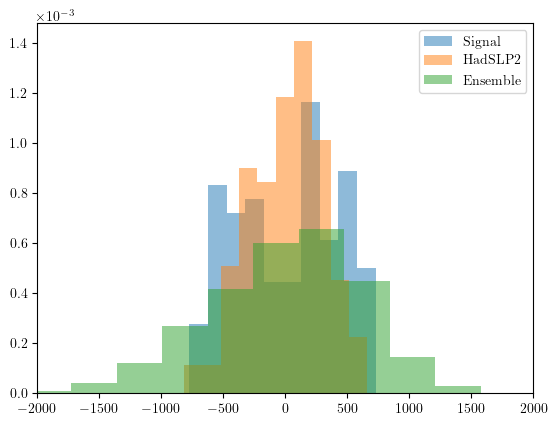

In [212]:
compute_stat_moments(120, -45, plot=True) # rho=0.4

In [184]:
compute_stat_moments(60, 0, plot=False) # rho=1.6

Lon=60, Lat=0
Sig -- mean=-0.074 | var=2000.987 | skew=-0.042 | kurt=-1.347
Obs -- mean=-0.0 | var=4208.045 | skew=-0.322 | kurt=-0.467
Ens -- mean=-0.0 | avgvar=10047.76499394655 | var=10034.633 | skew=-0.144 | kurt=-0.103
Model SNR = 0.44625942255541956
Obs SNR = 0.6471507417543502


# How does kurtosis relate to the SNP ($\rho>1$)? 
(Work in Progress)

In [219]:
# TODO: Make a map of the kurtosis!
def make_stat_map():
    _, y_len, x_len = s.psl.shape
    kurt = np.zeros((3, y_len, x_len))
    var = np.zeros((3, y_len, x_len))
    for y in tqdm(range(y_len)):
        for x in range(x_len):
            flat_s = s.isel(lon=x, lat=y).psl.to_numpy().flatten()
            flat_obs = obs.isel(lon=x, lat=y).psl.to_numpy().flatten()
            flat_obs = flat_obs[~np.isnan(flat_obs)]
            flat_f = f.isel(lon=x, lat=y).psl.to_numpy().flatten()
            flat_s = flat_s[~np.isnan(flat_s)]
            flat_obs = flat_obs[~np.isnan(flat_obs)]
            flat_f = flat_f[~np.isnan(flat_f)]

            s_mean, s_var, s_skew, s_kurt = np.round(nanmean(flat_s), 3), np.round(nanvar(flat_s),3), np.round(skew(flat_s),3), np.round(kurtosis(flat_s),3)
            obs_mean, obs_var, obs_skew, obs_kurt = np.round(nanmean(flat_obs), 3), np.round(nanvar(flat_obs),3), np.round(skew(flat_obs),3), np.round(kurtosis(flat_obs),3)
            f_mean, f_var, f_skew, f_kurt = np.round(nanmean(flat_f), 3), np.round(nanvar(flat_f),3), np.round(skew(flat_f),3), np.round(kurtosis(flat_f),3)
            
            var[:,y,x] = s_var, obs_var, f_var
            kurt[:,y,x] = s_kurt, obs_kurt, f_kurt
    return var, kurt

In [220]:
var_arr, kurt_arr = make_stat_map()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:26<00:00,  2.39it/s]


In [225]:
def plot_stats_over_earth(arr, vmin=0, vmax=2):
    fig, axs = plt.subplots(1,3, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

    normalizer = Normalize(vmin, vmax)
    im = cm.ScalarMappable(norm=normalizer, cmap='PuBu')
    axs[0].imshow(np.abs(arr[0]), norm=normalizer, cmap='PuBu', origin='lower', extent=(0, 360, -90, 90), transform=ccrs.PlateCarree())
    axs[1].imshow(np.abs(arr[1]), norm=normalizer, cmap='PuBu', origin='lower', extent=(0, 360, -90, 90), transform=ccrs.PlateCarree())
    axs[2].imshow(np.abs(arr[2]), norm=normalizer, cmap='PuBu', origin='lower', extent=(0, 360, -90, 90), transform=ccrs.PlateCarree())
    fig.colorbar(im, ax=(axs[0], axs[1], axs[2]), fraction=0.008, pad=0.02)

    titles = ["Signal", "Observation", "Ensemble"]
    for i in range(3):
        axs[i].coastlines()
        axs[i].set_title(titles[i])

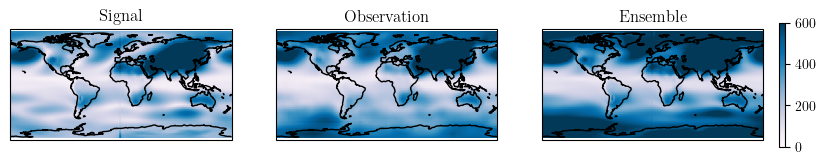

In [230]:
plot_stats_over_earth(np.sqrt(var_arr), vmin=0, vmax=600)

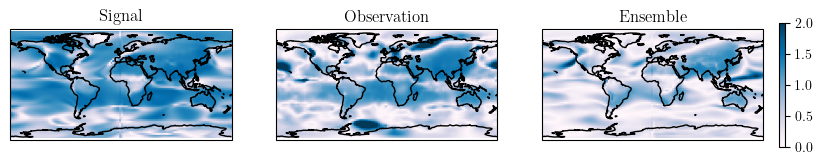

In [231]:
plot_stats_over_earth(kurt_arr)

# But the ratio of signal-observation variances has a good correlation with $\rho>1$...

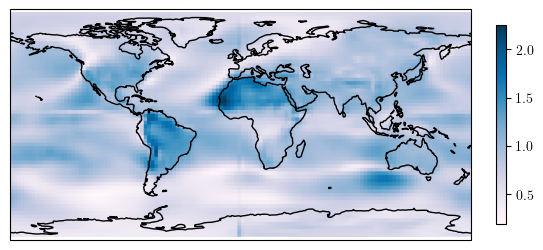

In [247]:
fig, axs = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = axs.imshow(np.sqrt(var_arr[0]/var_arr[1]), cmap='PuBu', origin='lower', extent=(0, 360, -90, 90), transform=ccrs.PlateCarree())
plt.colorbar(im, fraction=0.02)
axs.coastlines()